In [1]:
import numpy as np
from itertools import cycle
import os
import dask.array as da
import dask.bag as db
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xesmf as xe
import datetime as dt
import subprocess
from scipy.ndimage import binary_fill_holes
from importlib import reload
os.chdir("/home/149/ab8992/cosima_regional/regional-mom6/")


import regional_mom6 as rm
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/36259/status,
Dashboard: /proxy/36259/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35591,Workers: 7
Dashboard: /proxy/36259/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:38027,Total threads: 4
Dashboard: /proxy/38629/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:37603,


# TTide domain

In [2]:
## Choose your coordinates and the name of your experiment


yextent = [-56,-26]
xextent = [142,180]
expt_name = "blank-ttide-20"

pwd = "$KQ%QqFxjSSbE2"
usr = "abarnes"

# 
daterange = ["2015-01-01 00:00:00", "2015-12-31 00:00:00"]

## Place where all your input files go
inputdir = f"/g/data/nm03/ab8992/ttide-inputs/synbath/"

## Directory where you'll run the experiment from
rundir = f"/home/149/ab8992/tasman-tides/rundirs/blank-20-synbath/"

## Directory where raw downloads go before processing
tmpdir = f"/scratch/v45/ab8992/regional_tmp/ttide-20"

## Directory where fre tools are stored
toolpath = "/home/157/ahg157/repos/mom5/src/tools/" ## Compiled tools needed for construction of mask tables
for i in [rundir,tmpdir,inputdir]:
    if not os.path.exists(i):
        subprocess.run(f"mkdir {i} -p",shell=True)


expt = rm.experiment(
    xextent,
    yextent,
    daterange,
    0.05,  ## Resolution
    100,      ## #zlayers
    20,       ## dz ratio
    5500,    ## Max depth of ocean
    rundir,
    inputdir,
    toolpath
)

expt.bathymetry(
    '/g/data/v45/ab8992/synbath2/SYNBATH_V1.2.nc',
    {"xh":"lon",
     "yh":"lat",
     "elevation":"z"}, ## Again this dictionary just maps mom6 variable names to what they are in your topog.
     minimum_layers = 1,
     maketopog=False
    )




Reading in regridded bathymetry to fix up metadata...done.


In [9]:
expt.FRE_tools((25,20))

NOTE from make_solo_mosaic: there are 0 contacts (align-contact)
congradulation: You have successfully run make_solo_mosaic
MAKE SOLO MOSAIC

CompletedProcess(args='/home/157/ahg157/repos/mom5/src/tools/make_solo_mosaic/make_solo_mosaic --num_tiles 1 --dir . --mosaic_name ocean_mosaic --tile_file hgrid.nc', returncode=0)


cp: './ocean_mosaic.nc' and 'ocean_mosaic.nc' are the same file
cp: './hgrid.nc' and 'hgrid.nc' are the same file


cp ./hgrid.nc hgrid.nc 

NOTE from make_coupler_mosaic: the ocean land/sea mask will be determined by field depth from file topog.nc
mosaic_file is grid_spec.nc

***** Congratulation! You have successfully run make_quick_mosaic
QUICK MOSAIC

CompletedProcess(args='/home/157/ahg157/repos/mom5/src/tools/make_quick_mosaic/make_quick_mosaic --input_mosaic ocean_mosaic.nc --mosaic_name grid_spec --ocean_topog topog.nc', returncode=0)

 ===>NOTE from check_mask: when layout is specified, min_pe and max_pe is set to layout(1)*layout(2)=500

 ===>NOTE from check_mask: Below is the list of command line arguments.

grid_file = ocean_mosaic.nc
topog_file = topog.nc
min_pe = 500
max_pe = 500
layout = 25, 20
halo = 4
sea_level = 0
show_valid_only is not set
nobc = 0

 ===>NOTE from check_mask: End of command line arguments.

 ===>NOTE from check_mask: the grid file is version 2 (mosaic grid) grid which contains field gridfiles

==>NOTE from get_boundary_type: x_boundary_type is solid_walls

==>NOTE

## Compare synbath to gebco

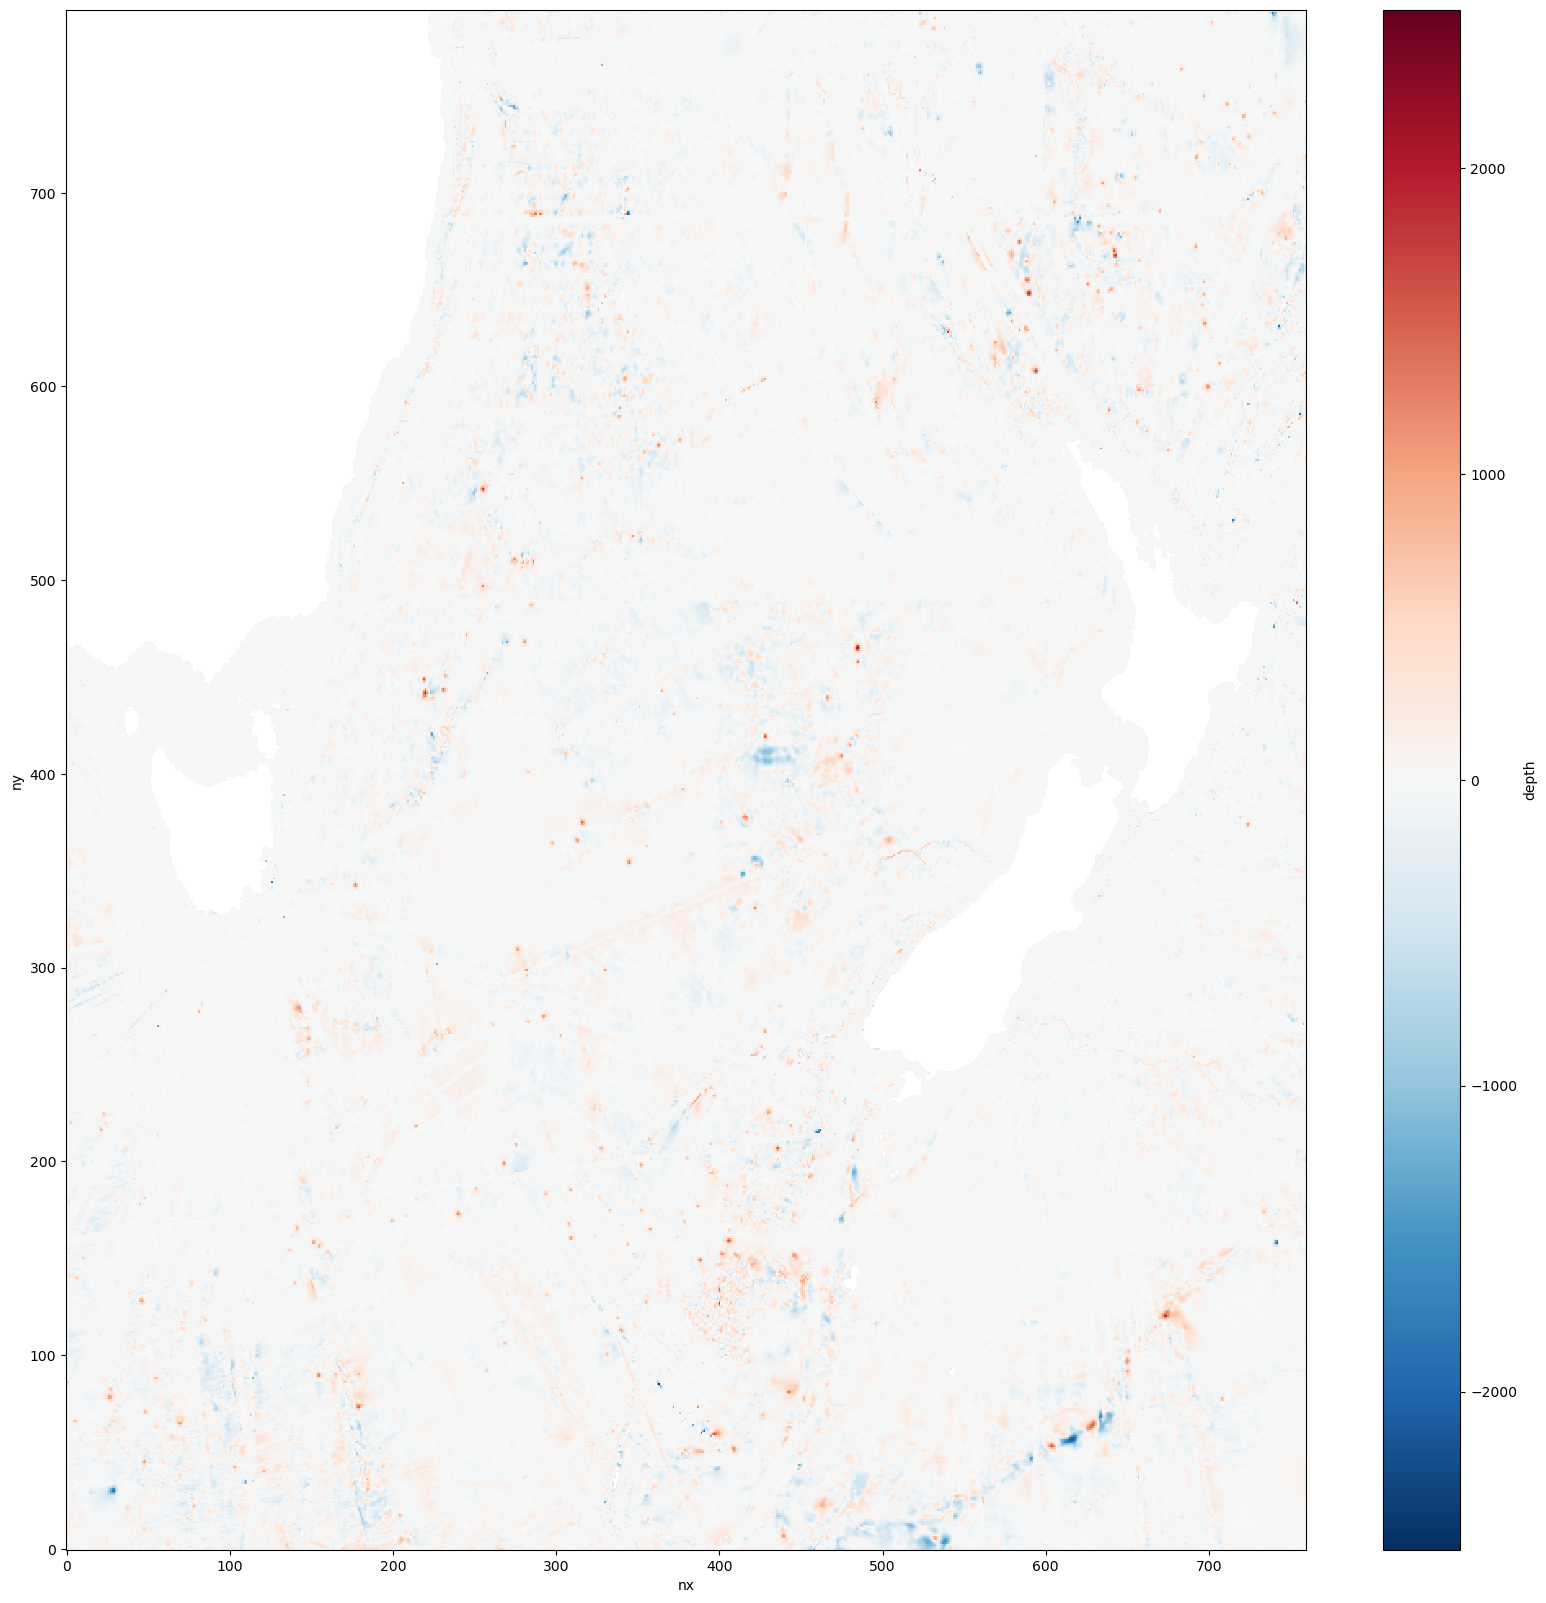

In [7]:
gebco = xr.open_dataset("/g/data/nm03/ab8992/ttide-inputs/default/topog.nc")
synbath = xr.open_dataset("/g/data/nm03/ab8992/ttide-inputs/synbath/topog.nc")

diff = gebco - synbath
plt.figure(figsize=(20,20))
diff.depth.plot()